In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Frequency tagging
## SNR

In [2]:
participants = ['A0', 'A1'] 
snr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_snr.csv', index_col=False)
    df_participant['participant'] = participant
    snr.append(df_participant)
snr = pd.concat(snr)
snr['cued_freq'] = snr['cued']
snr['SNR'] = snr['value']
snr['cued'] = (snr['freq'] == snr['cued_freq']).astype(int)

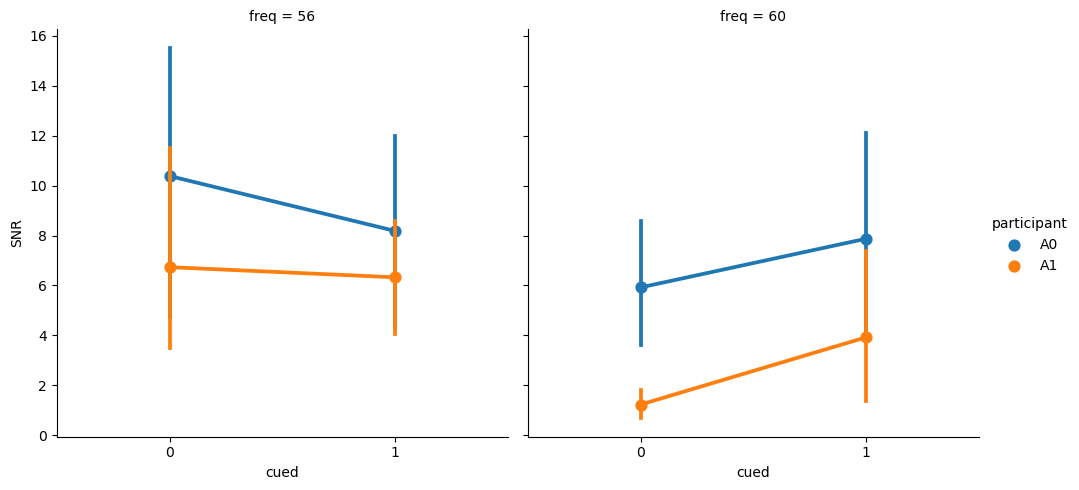

In [3]:
sns.catplot(y='SNR', x='cued', hue='participant', col='freq', data=snr, kind='point')

For an attentional effect, we expect the left plot to decrease and the right one to increase. Standard deviation are between the electrodes. 

In [4]:
# Average over electrodes
df_avg = snr.groupby(['freq', 'cued', 'participant', 'cued_freq'])['value'].mean().reset_index()
df_avg.loc[df_avg['freq'] == 56, 'freq'] = 0
df_avg.loc[df_avg['freq'] == 60, 'freq'] = 1
print(df_avg)

   freq  cued participant  cued_freq      value
0     0     0          A0         60  10.384258
1     0     0          A1         60   6.731866
2     0     1          A0         56   8.181988
3     0     1          A1         56   6.323909
4     1     0          A0         56   5.918575
5     1     0          A1         56   1.221617
6     1     1          A0         60   7.870787
7     1     1          A1         60   3.918653


In [5]:
md = smf.mixedlm("value ~ cued * freq", df_avg, groups=df_avg["participant"])
mdf = md.fit()
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 8       Method:             REML   
No. Groups:       2       Scale:              0.7250 
Min. group size:  4       Log-Likelihood:     -8.1903
Max. group size:  4       Converged:          Yes    
Mean group size:  4.0                                
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   8.558    1.845  4.638 0.000  4.942 12.174
cued       -1.305    0.851 -1.533 0.125 -2.974  0.364
freq       -4.988    0.851 -5.858 0.000 -6.657 -3.319
cued:freq   3.630    1.204  3.014 0.003  1.270  5.990
Group Var   6.083   12.013                           



## IT coherence

In [6]:
participants = ['A0', 'A1'] 
ITcoh = []
for participant in participants:
    df_participant = pd.read_csv(f'files/ITcoh_{participant}.csv', index_col=False)
    df_participant['participant'] = participant
    ITcoh.append(df_participant)
ITcoh = pd.concat(ITcoh)

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075

<Axes: xlabel='time', ylabel='ITcoherence'>

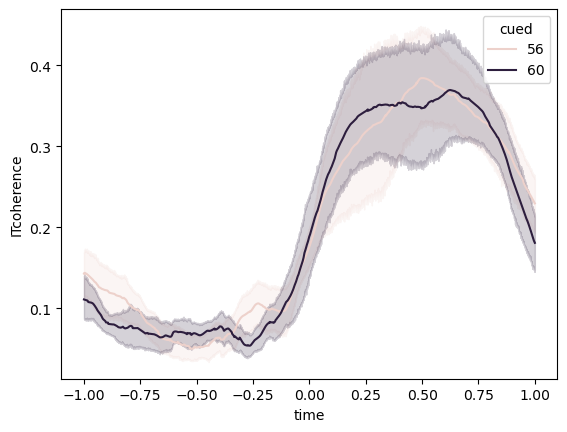

In [7]:
sns.lineplot(y='ITcoherence', hue='cued', x='time', data=ITcoh[ITcoh.coh_with == 56],)

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075

<Axes: xlabel='time', ylabel='ITcoherence'>

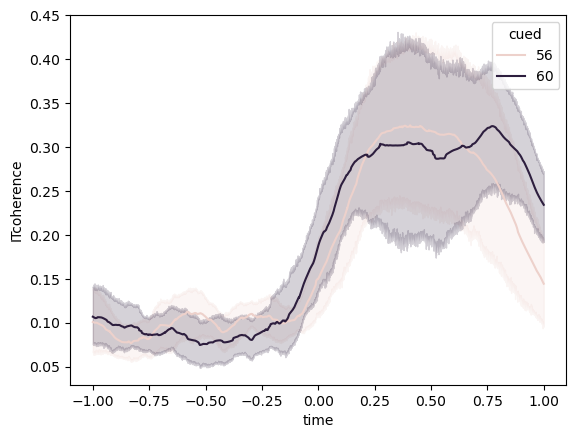

In [8]:
sns.lineplot(y='ITcoherence', hue='cued', x='time', data=ITcoh[ITcoh.coh_with == 60])

In [9]:
participants = ['A0', 'A1'] 
MScoh = []
for participant in participants:
    df_participant = pd.read_csv(f'files/MScoh_{participant}.csv', index_col=False)
    df_participant['participant'] = participant
    MScoh.append(df_participant)
MScoh = pd.concat(MScoh)

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075

<Axes: xlabel='time', ylabel='MScoherence'>

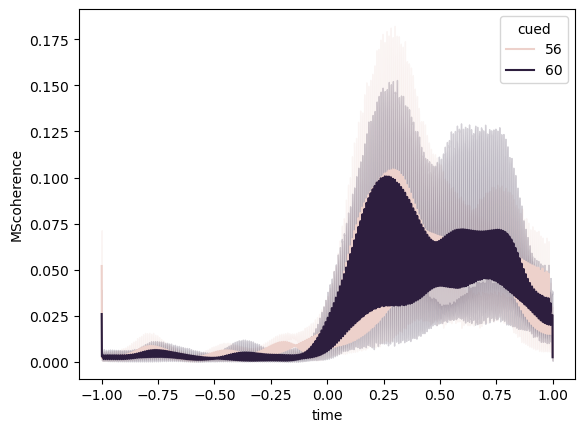

In [10]:
sns.lineplot(y='MScoherence', hue='cued', x='time', data=MScoh[MScoh.coh_with == 56])

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075

<Axes: xlabel='time', ylabel='MScoherence'>

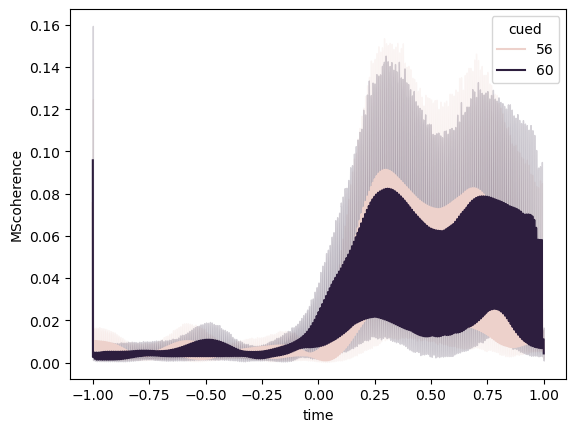

In [11]:
sns.lineplot(y='MScoherence', hue='cued', x='time', data=MScoh[MScoh.coh_with == 60])

# Cross-correlation
## Pre-post

In [19]:
participants = ['A0', 'A1'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_prepost.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)
crosscorr['Cor EEG/tag'] = crosscorr['value']

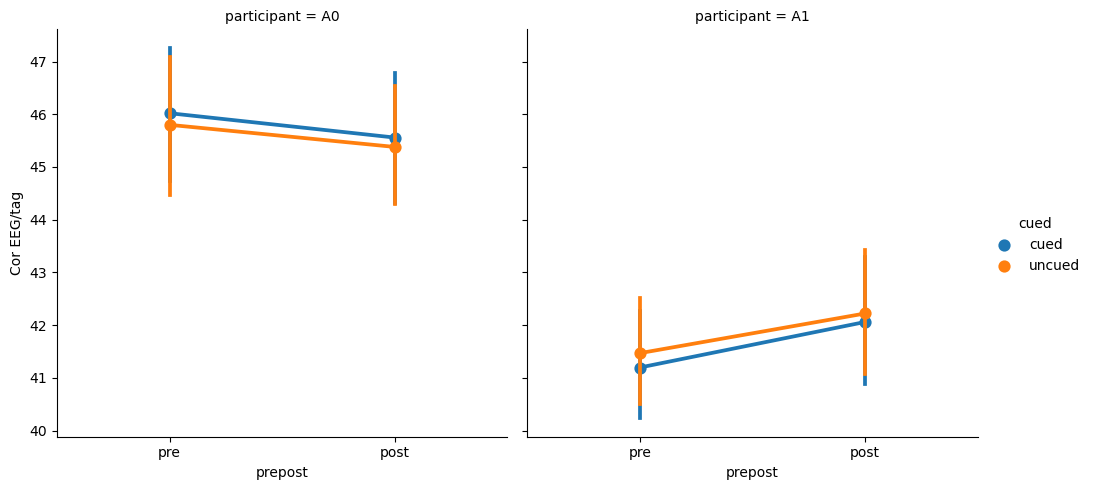

In [24]:
sns.catplot(y='Cor EEG/tag', x='prepost', hue='cued', col='participant', data=crosscorr, kind='point')

For an attentional effect, we expect the left plot to decrease and the right one to increase. Standard deviation are between the electrodes. 

In [25]:
# Average over electrodes
df_avg = crosscorr.groupby(['prepost', 'cued', 'participant'])['value'].mean().reset_index()
df_avg.loc[df_avg['prepost'] == 'pre', 'prepost'] = 0
df_avg.loc[df_avg['prepost'] == 'post', 'prepost'] = 1
df_avg.loc[df_avg['cued'] == 'uncued', 'cued'] = 0
df_avg.loc[df_avg['cued'] == 'cued', 'cued'] = 1
print(df_avg)

  prepost cued participant      value
0       1    1          A0  45.557705
1       1    1          A1  42.060763
2       1    0          A0  45.379824
3       1    0          A1  42.221880
4       0    1          A0  46.019421
5       0    1          A1  41.197098
6       0    0          A0  45.799023
7       0    0          A1  41.469514


In [26]:
md = smf.mixedlm("value ~ cued * prepost", df_avg, groups=df_avg["participant"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     value  
No. Observations:     8           Method:                 REML   
No. Groups:           2           Scale:                  0.2896 
Min. group size:      4           Log-Likelihood:         -6.9239
Max. group size:      4           Converged:              Yes    
Mean group size:      4.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              43.634    2.003 21.783 0.000 39.708 47.560
cued[T.1]              -0.026    0.538 -0.048 0.961 -1.081  1.029
prepost[T.1]            0.167    0.538  0.310 0.757 -0.888  1.221
cued[T.1]:prepost[T.1]  0.034    0.761  0.045 0.964 -1.457  1.526
Group Var               7.735   23.693                           

